<a href="https://colab.research.google.com/github/RohanHanda/Facial-Expression-Recognizer/blob/main/FacialExpRecog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [ ]:
def init_weight_and_bias(M1,M2):
  W = np.random.randn(M1,M2)/np.sqrt(M1+M2)
  b = np.zeros(M2)
  return W.astype(np.float32), b.astype(np.float32)

In [ ]:
def init_filter(shape,poolsz):
  w = np.random.randn(*shape)/np.sqrt(np.prod(shape[1:])+shape[0]*np.prod(shape[2:]/np.prod(poolsz)))
  return w.astype(np.float32)

In [ ]:
def relu(X):
  return X*(X>0)

In [ ]:
def sigmoid(A):
  return 1/(1+np.exp(-A))

In [ ]:
def softmax(a):
  expA = np.exp(a)
  return expA/expA.sum(axis=1,keepdims=True)

In [ ]:
def sigmoid_cost(T,Y):
  return -(T*np.log(Y) + (1-T)*np.log(1-Y)).sum()

In [ ]:
def cost(T,Y):
  return -(T*np.log(Y)).sum()

In [ ]:
def cost2(T,Y):
  N = len(T)
  return -np.log(Y[np.arange(N),T]).sum()

In [ ]:
def error_rate(T,Y):
  return np.mean(T!=Y)

In [ ]:
def y2indicator(y):
  N=  len(y)
  K = len(set(y))
  ind = np.zeros((N,K))
  for i in range(N):
    ind[i,y[i]] = 1  # Corrected from y(i) to y[i]
  return ind

In [ ]:
def getData(balance_ones=True, Ntest=1000):
    # images are 48x48 = 2304 size vectors
    Y = []
    X = []
    first = True
    for line in open('/content/drive/MyDrive/Colab_Notebooks/machine_learning_examples/large_files/fer2013.csv'):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)

    # shuffle and split
    X, Y = shuffle(X, Y)
    Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
    Xvalid, Yvalid = X[-Ntest:], Y[-Ntest:]

    if balance_ones:
        # balance the 1 class
        X0, Y0 = Xtrain[Ytrain!=1, :], Ytrain[Ytrain!=1]
        X1 = Xtrain[Ytrain==1, :]
        X1 = np.repeat(X1, 9, axis=0)
        Xtrain = np.vstack([X0, X1])
        Ytrain = np.concatenate((Y0, [1]*len(X1)))

    return Xtrain, Ytrain, Xvalid, Yvalid



In [ ]:
def getImageData():
  Xtrain,Ytrain,Xvalid,Yvalid = getData()
  N,D = Xtrain.shape
  d = int(np.sqrt(D))
  Xtrain = Xtrain.reshape(-1, 1, d, d)
  Xvalid = Xvalid.reshape(-1, 1, d, d)
  return Xtrain, Ytrain, Xvalid, Yvalid

In [ ]:
def getBinaryData():
    Y = []
    X = []
    first = True
    for line in open('fer2013.csv'):
        if first:
            first = False
        else:
            row = line.split(',')
            y = int(row[0])
            if y == 0 or y == 1:
                Y.append(y)
                X.append([int(p) for p in row[1].split()])
    return np.array(X) / 255.0, np.array(Y)

In [ ]:
class ANN(object):
    def __init__(self, M):
        self.M = M

    def fit(self, X, Y, learning_rate=5e-7, reg=1.0, epochs=10000, show_fig=False):
        X, Y = shuffle(X, Y)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]

        N, D = X.shape
        self.W1 = np.random.randn(D, self.M) / np.sqrt(D)
        self.b1 = np.zeros(self.M)
        self.W2 = np.random.randn(self.M) / np.sqrt(self.M)
        self.b2 = 0

        costs = []
        best_validation_error = 1
        for i in range(epochs):
            # forward propagation and cost calculation
            pY, Z = self.forward(X)

            # gradient descent step
            pY_Y = pY - Y
            self.W2 -= learning_rate*(Z.T.dot(pY_Y) + reg*self.W2)
            self.b2 -= learning_rate*((pY_Y).sum() + reg*self.b2)

            # print "(pY_Y).dot(self.W2.T) shape:", (pY_Y).dot(self.W2.T).shape
            # print "Z shape:", Z.shape
            dZ = np.outer(pY_Y, self.W2) * (Z > 0)
            # dZ = np.outer(pY_Y, self.W2) * (1 - Z*Z)
            self.W1 -= learning_rate*(X.T.dot(dZ) + reg*self.W1)
            self.b1 -= learning_rate*(np.sum(dZ, axis=0) + reg*self.b1)

            if i % 20 == 0:
                pYvalid, _ = self.forward(Xvalid)
                c = sigmoid_cost(Yvalid, pYvalid)
                costs.append(c)
                e = error_rate(Yvalid, np.round(pYvalid))
                print("i:", i, "cost:", c, "error:", e)
                if e < best_validation_error:
                    best_validation_error = e
        print("best_validation_error:", best_validation_error)

        if show_fig:
            plt.plot(costs)
            plt.show()


    def forward(self, X):
        Z = relu(X.dot(self.W1) + self.b1)
        # Z = np.tanh(X.dot(self.W1) + self.b1)
        return sigmoid(Z.dot(self.W2) + self.b2), Z


    def predict(self, X):
        pY = self.forward(X)
        return np.round(pY)


    def score(self, X, Y):
        prediction = self.predict(X)
        return 1 - error_rate(Y, prediction)

In [ ]:
def main():
    X, Y = getBinaryData()

    X0 = X[Y==0, :]
    X1 = X[Y==1, :]
    X1 = np.repeat(X1, 9, axis=0)
    X = np.vstack([X0, X1])
    Y = np.array([0]*len(X0) + [1]*len(X1))

    model = ANN(100)
    model.fit(X, Y, show_fig=True)

i: 0 cost: 709.5416990593918 error: 0.508
i: 20 cost: 683.5073099154671 error: 0.422
i: 40 cost: 678.9832820684614 error: 0.409
i: 60 cost: 674.9871875812564 error: 0.387
i: 80 cost: 671.5772125291716 error: 0.379
i: 100 cost: 668.745182754034 error: 0.377
i: 120 cost: 666.2843350396922 error: 0.381
i: 140 cost: 664.0109968883401 error: 0.384
i: 160 cost: 661.8410385884232 error: 0.372
i: 180 cost: 659.7826757407502 error: 0.367
i: 200 cost: 657.7826006760429 error: 0.364
i: 220 cost: 655.8192753502849 error: 0.368
i: 240 cost: 653.9565864111444 error: 0.365
i: 260 cost: 652.2502891959227 error: 0.367
i: 280 cost: 650.5803260410648 error: 0.366
i: 300 cost: 649.0353788747306 error: 0.362
i: 320 cost: 647.5349351200666 error: 0.357
i: 340 cost: 646.0867142779982 error: 0.357
i: 360 cost: 644.6944153104373 error: 0.352
i: 380 cost: 643.336745263484 error: 0.35
i: 400 cost: 642.0325725368193 error: 0.35
i: 420 cost: 640.7605655958855 error: 0.345
i: 440 cost: 639.5307855811687 error: 0.34

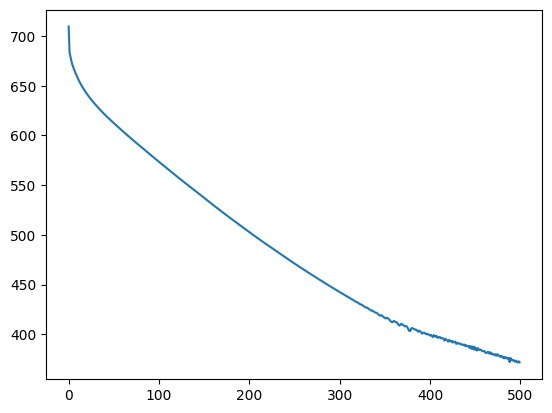

In [ ]:
main()

In [ ]:
class LogisticModel(object):
    def __init__(self):
        pass
    def fit(self,X,Y,Xvalid,Yvalid,learning_rate = 10e-8, reg=10e-12,epochs=10000,show_fig=False):
      N,D = X.shape
      K = len(set(Y))
      self.W = np.random.randn(D,K)/np.sqrt(D)
      self.b = np.zeros(K)
      costs = []
      best_validation_error = 1
      T = y2indicator(Y)
      Tvalid = y2indicator(Yvalid)
      for i in range(epochs):
        pY = self.forward(X)
        self.W -= learning_rate*(X.T.dot(pY-T)+reg*self.W)
        self.b -= learning_rate*((pY-T).sum(axis=0) + reg*self.b)
        if i %10== 0:
          pYvalid = self.forward(Xvalid)
          c = cost(Tvalid,pYvalid)
          costs.append(c)
          e = error_rate(Yvalid,np.argmax(pYvalid,axis=1))
          print("i:",i,"cost:",c,"error:",e)
          if e<best_validation_error:
            best_validation_error = e
      print("Best error: ",best_validation_error)
      if show_fig:
        plt.plot(costs)
        plt.show()
    def forward(self, X):
      return softmax(X.dot(self.W)+self.b)
    def predict(self, X):
      pY = self.forward(X)
      return np.argmax(pY,axis=1)
    def score(self,X,Y):
      prediction = self.predict(X)
      return 1-error_rate(Y,prediction)


In [ ]:
def main():
  Xtrain,Ytrain,Xvalid,Yvalid = getData()
  model = LogisticModel()
  model.fit(Xtrain,Ytrain,Xvalid,Yvalid,show_fig=True)
  print("Score: ",model.score(Xvalid,Yvalid))

i: 0 cost: 2016.1859587961615 error: 0.862
i: 10 cost: 1917.7521286431625 error: 0.762
i: 20 cost: 1913.972608953375 error: 0.76
i: 30 cost: 1910.7176320583994 error: 0.759
i: 40 cost: 1907.7141515242188 error: 0.756
i: 50 cost: 1904.9236183157102 error: 0.758
i: 60 cost: 1902.3144482261725 error: 0.757
i: 70 cost: 1899.86067386481 error: 0.756
i: 80 cost: 1897.5409659812613 error: 0.757
i: 90 cost: 1895.3377550888324 error: 0.759
i: 100 cost: 1893.2365171042898 error: 0.756
i: 110 cost: 1891.225197048927 error: 0.757
i: 120 cost: 1889.2937449246847 error: 0.754
i: 130 cost: 1887.4337421455675 error: 0.752
i: 140 cost: 1885.638100810761 error: 0.75
i: 150 cost: 1883.9008214396183 error: 0.749
i: 160 cost: 1882.2167975689463 error: 0.749
i: 170 cost: 1880.5816578969736 error: 0.748
i: 180 cost: 1878.991638514779 error: 0.748
i: 190 cost: 1877.4434792634856 error: 0.748
i: 200 cost: 1875.9343394571677 error: 0.747
i: 210 cost: 1874.4617291720429 error: 0.748
i: 220 cost: 1873.02345306866

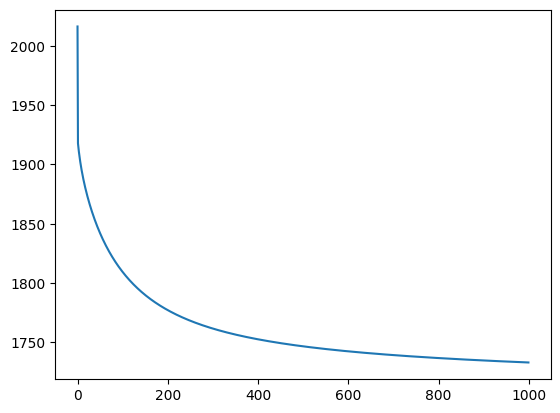

Score:  0.33599999999999997


In [ ]:
main()

In [ ]:
class ANN(object):
  def __init__(self,M):
    self.M = M

  def fit(self,X,Y, Xvalid,Yvalid,learning_rate=0.00001,reg=0.1,epochs=10000,show_fig=False):
    N,D = X.shape
    K = len(set(Y))
    T = y2indicator(Y)
    self.W1 = np.random.randn(D,self.M)/np.sqrt(D)
    self.b1 = np.zeros(self.M)
    self.W2 = np.random.randn(self.M,K)/np.sqrt(self.M)
    self.b2 = np.zeros(K)
    costs = []
    best_validation_error = 1
    for i in range(epochs):
      pY,Z = self.forward(X)
      pY_T = pY-T
      self.W2 -= learning_rate*(Z.T.dot(pY_T) + reg*self.W2)
      self.b2 -= learning_rate*(pY_T.sum(axis=0)+reg*self.b2)
      dZ = pY_T.dot(self.W2.T)*(1-Z*Z)
      self.W1 -= learning_rate*(X.T.dot(dZ)+reg*self.W1)
      self.b1 -= learning_rate*(dZ.sum(axis=0)+reg*self.b1)
      if i%10 == 0:
        pYvalid,_ = self.forward(Xvalid)
        c = cost2(Yvalid,pYvalid)
        costs.append(c)
        e = error_rate(Yvalid,np.argmax(pYvalid,axis=1))
        print("i:",i,"cost:",c,"error:",e)
        if e<best_validation_error:
          best_validation_error = e
    print("Best error: ",best_validation_error)
    if show_fig:
      plt.plot(costs)
      plt.show()
  def forward(self,X):
    Z = np.tanh(X.dot(self.W1)+self.b1) # Corrected matrix multiplication
    return softmax(Z.dot(self.W2)+self.b2),Z
  def predict(self,X):
    pY,_ = self.forward(X)
    return np.argmax(pY,axis=1)
  def score(self,X,Y):
    prediction = self.predict(X)
    return 1-error_rate(Y,prediction)

In [ ]:
def main():
  Xtrain,Ytrain,Xvalid,Yvalid = getData()
  model = ANN(400)
  model.fit(Xtrain,Ytrain,Xvalid,Yvalid,show_fig=True)
  print("Score: ",model.score(Xvalid,Yvalid))

In [ ]:
main()

i: 0 cost: 5090.062828133783 error: 0.923
i: 10 cost: 31975.110115657808 error: 0.738
i: 20 cost: 61622.86695899044 error: 0.874
i: 30 cost: 90618.57932411408 error: 0.858
i: 40 cost: 65620.50357762295 error: 0.858


KeyboardInterrupt: 